# <center> CAN Log File Analysis
## <center> ENGR 580A2: Secure Vehicle and Industrial Networking
## <center><img src="https://www.engr.colostate.edu/~jdaily/Systems-EN-CSU-1-C357.svg" width="400" />
### <center> Instructor: Dr. Jeremy Daily

## Objective
* Work through examples of converting log files from different formats into the Linux SocketCAN format.
* Extract signals from SAE J1939 traces and plot them.

This notebook can be run on Windows or Linux.

In [1]:
# Use the struct library to interpret bytes
import struct
#Use the time libary to work with the timestamps
import time

# Log File Conversions
Often CAN logs are in different formats based on the tool used to collect the data. This section provides a demonstration on how to convert from one format to the Linux can-utils candump format. The goal is to list all CAN messages in the following format:
```
(UNIX Timestamp) channel CANID#DATA
```
The data length code is determined by the length of the data field.

Extended IDs will have 8 characters in the CAN ID and 3 characters (nibbles) if the standard 11-bit arbitration identifiers are used.

The can-utils package that includes `candump` is here: https://github.com/linux-can/can-utils

Additional information can be found by examining the SocketCAN documentation here: https://www.kernel.org/doc/html/v4.17/networking/can.html

Finally, some of the manual pages show the candump format and structure: https://manpages.debian.org/bullseye/can-utils/candump.1.en.html

## Vehicle Spy
The Intrepid Vehicle Spy software is a popular software for working with CAN and J1939. The low-cost ValueCAN device enables engineers to quickly connect to networks and see traffic. In this example, there is a file that was recorded using VSPY3 called `VSpy on a Kenworth.csv`.


In [2]:
# Read the data into Python
with open("VSpy on a Kenworth.csv", "r") as f:
    lines = f.readlines()
lines[:200]

['Vehicle Spy 3 Bus Traffic File\n',
 'Save Date,11/29/2018\n',
 'Save Time,3:53:39 pm\n',
 'Start Date,11/29/2018\n',
 'Start Time,3:53:21 pm\n',
 'System Time,6132156\n',
 'Notes,\n',
 '\n',
 'Network Description,Hardware,Network,Protocol,Baud Rate\n',
 'HS CAN,Default,HS CAN,CAN,500000,\n',
 'MS CAN,Default,MS CAN,CAN,500000,\n',
 'SW CAN,Default,SW CAN,CAN,33333,\n',
 'J1850 VPW,Default,J1850 VPW,J1850 VPW,10417,\n',
 'ISO9141/KW2K,Default,ISO9141/KW2K,KeyWord 2000,10417,\n',
 'LSFT CAN,Default,LSFT CAN,CAN,125000,\n',
 'J1850 PWM,Default,J1850 PWM,J1850 PWM,41600,\n',
 'J1708,Default,J1708,J1708,9600,\n',
 'neoVI,Default,neoVI,CAN,,\n',
 'HS CAN2 (neoVI 3G),Default,HS CAN2 (neoVI 3G),CAN,500000,\n',
 'HS CAN3 (neoVI 3G),Default,HS CAN3 (neoVI 3G),CAN,500000,\n',
 'LIN2 (neoVI 3G),Default,LIN2 (neoVI 3G),LIN,10417,\n',
 'LIN3 (neoVI 3G),Default,LIN3 (neoVI 3G),LIN,10417,\n',
 'LIN4 (neoVI 3G),Default,LIN4 (neoVI 3G),LIN,10417,\n',
 'CGI (neoVI 3G),Default,CGI (neoVI 3G),CGI,625000,

In [3]:
# confirm this is a Vehicle Spy file
# The following will raise and exception if it's not true.
assert "Vehicle Spy 3" in lines[0] 

In [4]:
#Extract the start date 
start_date = lines[3].strip().split(',')[1]
start_date

'11/29/2018'

In [5]:
#Extract the start time 
start_time = lines[4].strip().split(',')[1]
start_time

'3:53:21 pm'

See https://docs.python.org/3/library/time.html#time.strftime for the format strings for the time function

In [6]:
# Make a full time string and assume mountain time
time_string = start_date + ' ' + start_time + " -0700"
time_string

'11/29/2018 3:53:21 pm -0700'

In [7]:
#Convert these to a time object
log_time = time.strptime(time_string, "%m/%d/%Y %I:%M:%S %p %z") 
log_time

time.struct_time(tm_year=2018, tm_mon=11, tm_mday=29, tm_hour=15, tm_min=53, tm_sec=21, tm_wday=3, tm_yday=333, tm_isdst=-1)

In [8]:
# Determine the number of seconds from the Unix epoch
log_time_offset = time.mktime(log_time)
log_time_offset

1543532001.0

In [9]:
# Find the starting line
start_line = 0
for line in lines:
    if "1," in line[:2]: #The text of the first line
        break
    else:
        start_line+=1
start_line # this should be the line number where the log data starts

97

In [10]:
line

'1,2.570999999999998,0,67371012,F,F,HS CAN $18F00131,HS CAN,,18F00131,F,T,FF,FF,FF,3F,00,FF,FF,FF,,,\n'

In [11]:
# Here's the first header
lines[start_line-2]

'Line,Abs Time(Sec),Rel Time (Sec),Status,Er,Tx,Description,Network,Node,Arb ID,Remote,Xtd,B1,B2,B3,B4,B5,B6,B7,B8,Value,Trigger,Signals\n'

In [12]:
# Here's the second header
lines[start_line-1]

'Line,Abs Time(Sec),Rel Time (Sec),Status,Er,Tx,Description,Network,Node,PT,Trgt,Src,B1,B2,B3,B4,B5,B6,B7,B8,Value,Trigger,Signals\n'

In [13]:
# Extract the first line
line = lines[97]
line

'1,2.570999999999998,0,67371012,F,F,HS CAN $18F00131,HS CAN,,18F00131,F,T,FF,FF,FF,3F,00,FF,FF,FF,,,\n'

We have a comma separated values line with a format shown in the first header. To convert this into a list, we'll use the split command. But first, we'll need to strip off the whitespace. 

In [14]:
line.strip().split(',')

['1',
 '2.570999999999998',
 '0',
 '67371012',
 'F',
 'F',
 'HS CAN $18F00131',
 'HS CAN',
 '',
 '18F00131',
 'F',
 'T',
 'FF',
 'FF',
 'FF',
 '3F',
 '00',
 'FF',
 'FF',
 'FF',
 '',
 '',
 '']

In [15]:
# Let's create an index key for each line
header = lines[start_line-2].strip().split(',')
for i,head in zip(range(len(header)),header):
    print("{:2d} {}".format(i,head))

 0 Line
 1 Abs Time(Sec)
 2 Rel Time (Sec)
 3 Status
 4 Er
 5 Tx
 6 Description
 7 Network
 8 Node
 9 Arb ID
10 Remote
11 Xtd
12 B1
13 B2
14 B3
15 B4
16 B5
17 B6
18 B7
19 B8
20 Value
21 Trigger
22 Signals


To convert to `candump`, use the time, Arb ID, and data bytes.

Let's assume the `HS CAN` channel maps to `can1`.

We'll work through all the file to produce this new record.

In [16]:
#Create an empty string
candump_string = ""
# Iterate through the log file and concatenate the next line
for line in lines[start_line:200]:
    line_list = line.strip().split(',')
    # Extract the network as the channel:
    channel = line_list[7]
    if "HS CAN" in channel:
        channel = 'can1'
    elif "MS CAN" in channel:
        channel = 'can0'
    else:
        continue # This line wasn't from the CAN
    
    #Convert the time into a floating point number to measure the number of seconds
    abs_time = float(line_list[1]) + log_time_offset
    
    #Convert the CANID from hex to an integer
    can_id = int(line_list[9],16)
    
    # Create bytes from the data
    # The data is orignally in a text format and it needs to be converted into a long string
    # Location 12-19 have the bytes, but the last value in the list slice is not indexed
    can_data_string = "".join(line_list[12:20])
    can_data = bytes.fromhex(can_data_string)
    
    candump_string += "({:0.6f}) {} {:08X}#{}\n".format(abs_time,
                                                         channel,
                                                         can_id,
                                                         can_data_string)
    
print(candump_string)

(1543532003.571000) can1 18F00131#FFFFFF3F00FFFFFF
(1543532003.571588) can1 18E0FF31#00FFFFFFFFF0FFFF
(1543532003.572164) can1 18FEF131#F7FFFFC7CCFFFFFF
(1543532003.572760) can1 18FEF031#FFFFFFFFFFFFFFFF
(1543532003.573344) can1 18FEFC31#FF1FFFFFFFFF00FF
(1543532003.573924) can1 18FEAE31#FFFF6E6EFFFFFFFF
(1543532003.574516) can1 18FEF731#FFFFFFFFFA00FFFF
(1543532003.575108) can1 18FF0431#409CFFFFFFFFFFFF
(1543532003.575708) can1 18FF5031#FFFFFFFFFFFAFFFF
(1543532003.576308) can1 18FD8331#F8FFFFFFFFFFFFFF
(1543532003.576900) can1 18FEFA31#00DCDCFFFFFFFFFF
(1543532003.577496) can1 18FEF231#FFFFFFFFFFFFFFFF
(1543532003.578100) can1 18FEF831#FFFFFFFFFFFFFFFF
(1543532003.578684) can1 18FEC131#1710310AFFFFFFFF
(1543532003.579284) can1 0CF00331#FFFFFFFFFFFFFFFF
(1543532003.581404) can1 18EA00F9#ECFE00
(1543532003.581964) can1 18FECA31#C0FFA800117EFFFF
(1543532003.620991) can1 0CF00331#FFFFFFFFFFFFFFFF
(1543532003.671001) can1 18F00131#FFFFFF3F00FFFFFF
(1543532003.671573) can1 18FEF131#F7FFFF0

In [17]:
# Save this to a file
with open('candump on a Kenworth.log','w') as f:
    f.write(candump_string)

Now we can use this file for other purposes, like replaying the data through `canplayer` on a Raspberry Pi.

Note: there are more efficient ways to combine these steps by reading and converting the file line by line as opposed to dumping everything in memory. This is an important consideration if you have large log files on an embedded device. 

## Class Exercise: Convert the Vector file
Convert the file called `Vector CAN Case XL on Freightliner.csv` to the candump format.

In [18]:
# Read the data into Python
with open("Vector CAN Case XL on Freightliner.csv", "rb") as f:
    lines = f.readlines()
lines[:200]

[b';Timestamp [s],Timediff[\xb5s],Trigger Type,Event Type,Data,Data,Data,Data\r\n',
 b'0.000000,+1332170382000000\xb5s,,Realtime (83),Mon Mar 19 15:19:42 2012\r\n',
 b'0.000000,+0\xb5s,Single,Session Start (4484),ID:c0015b89\r\n',
 b'0.000000,+0\xb5s,On/Off,BUS INFO (4c2),ch:1,Baudrate:1443, Silent:1, Protocol:0, Pre-Trigger:0, Post-Trigger:0, Fw:6081f201\r\n',
 b'0.000000,+0\xb5s,On/Off,BUS INFO (84c2),ch:2,Baudrate:1443, Silent:0, Protocol:0, Pre-Trigger:0, Post-Trigger:0, Fw:6081f201\r\n',
 b'143.783033,+143783033\xb5s,On/Off,CAN (4a8),RX ch:1,Dlc:8,idx:,301,data:,09,6f,a7,3b,0a,b8,0c,98,\r\n',
 b'143.783594,+561\xb5s,On/Off,CAN (4a8),RX ch:1,Dlc:8,idx:,302,data:,1d,35,19,85,00,0c,7e,6f,\r\n',
 b'143.784174,+580\xb5s,On/Off,CAN (4a8),RX ch:1,Dlc:8,idx:,303,data:,00,00,00,00,02,63,8c,01,\r\n',
 b'143.784770,+596\xb5s,On/Off,CAN (4a8),RX ch:1,Dlc:8,idx:,304,data:,00,00,00,00,00,00,00,00,\r\n',
 b'143.785354,+584\xb5s,On/Off,CAN (4a8),RX ch:1,Dlc:8,idx:,305,data:,00,00,49,c7,00,00,00,0

In [19]:
lines[5].decode('utf-8','ignore')

'143.783033,+143783033s,On/Off,CAN (4a8),RX ch:1,Dlc:8,idx:,301,data:,09,6f,a7,3b,0a,b8,0c,98,\r\n'

In [20]:
start_line = 5

In [21]:
#Create an empty string
candump_string = ""
# Iterate through the log file and concatenate the next line
for line in lines[start_line:200]: #Change this to get the whole file
    line_string = line.decode('utf-8','ignore')
    line_list = line_string.strip().split(',')
    # Extract the network as the channel:
    channel = line_list[4]
    if "ch:1" in channel:
        channel = 'can1'
    elif "ch:0" in channel:
        channel = 'can0'
    else:
        continue # This line wasn't from the CAN
    
    #Convert the time into a floating point number to measure the number of seconds
    abs_time = float(line_list[0]) #+ log_time_offset
    
    #Convert the CANID from hex to an integer
    try:
        can_id = int(line_list[7],16)
    except ValueError:
        continue
    
    # Create bytes from the data
    # The data is orignally in a text format and it needs to be converted into a long string
    # Location 12-19 have the bytes, but the last value in the list slice is not indexed
    can_data_string = "".join(line_list[9:17])
    can_data = bytes.fromhex(can_data_string)
    
    if len(line_list[7]) <= 3:
        id_string = "     {:03X}".format(can_id)
    else:
        id_string = "{:08X}".format(can_id)
    
    candump_string += "({:0.6f}) {} {}#{}\n".format(abs_time,
                                                         channel,
                                                         id_string,
                                                         can_data_string)
    
print(candump_string)

(143.783033) can1      301#096fa73b0ab80c98
(143.783594) can1      302#1d351985000c7e6f
(143.784174) can1      303#0000000002638c01
(143.784770) can1      304#0000000000000000
(143.785354) can1      305#000049c700000000
(143.785946) can1      306#000c000000000000
(143.786426) can1      308#00042fe4eb7b0000
(143.786898) can1      309#fff4974207f40000
(143.787362) can1      310#39ea7029b5b2d4be
(143.787814) can1      311#bd4ff924bb037596
(143.788266) can1      312#bf428f5c3f3d70a4
(143.788718) can1      313#bcf5c28f3f7d8c9e
(143.789270) can1 0CF00400#f07d89861200ff89
(143.789850) can1 14FF3131#0030030000ffffff
(143.790434) can1 18F00100#ffffffffffffffff
(143.791902) can1 14F00031#cfffffffffffffff
(143.792867) can1      301#096fa73c0ab80c98
(143.793431) can1      302#1d35198500067e0f
(143.794011) can1      303#0000000003638c01
(143.794607) can1      304#0000000000000000
(143.795191) can1      305#000049c700000000
(143.795787) can1      306#0008000000000000
(143.796263) can1      308#00042

In [22]:
# Save this to a file
with open('candump for CAN Case XL on Freightliner.log','w') as f:
    f.write(candump_string)

### Section Summary
We have worked through 2 examples of how to convert log files of different formats into a candump file format. Now, let's analyze the data

# CAN Log File Analysis
Given a log file in the candump format, what does it say? 

To address this question, let's characterize the messages based on their IDs. To do this, we'll use the dictionary structure to keep track of the message counts and other meta data. Then we can plot the information.

In [23]:
# We can also plot this
import matplotlib.pyplot as plt

In [24]:
# Define a function to get CAN data in a usable form from candump formats.
def parse_candump(line):
    #Strip the new-line characters and split based on whitespace
    line_as_list = line.strip().split()
    #extract the text characters from the first entry and remove the parens.
    time_string = line_as_list[0].strip('()')
    
    #Assume UTC for the time zone
    timestamp = float(time_string)
    
    #extract the string representing the physical CAN channel
    channel = line_as_list[1]
    
    # Split the last entry into the ID and the data fields based on the hash
    can = line_as_list[2].split('#')
    
    #Convert the ID into an integer
    can_id = int(can[0],16)
    
    #Convert the data into bytes
    can_data = bytes.fromhex(can[1])
    
    #Determine the data length code
    dlc = len(can_data)
    
    return timestamp, channel, can_id, dlc, can_data

In [26]:
# Initialize the dictionary. The keys will be the IDs and the values will be the count
can_id_dict = {}
with open('candump_kw_drive.txt', 'r') as f:
    for line in f:
        timestamp, channel, can_id, dlc, can_data = parse_candump(line)
        try:
            # Add another to the count for each ID
            can_id_dict[can_id] += 1
        except KeyError:
            # The ID wasn't in the dictionary, so let's initialize it
            can_id_dict[can_id] = 1
can_id_dict 

{419348235: 8175,
 150892043: 20436,
 217056256: 41156,
 217056000: 8231,
 418382129: 4116,
 419361024: 4116,
 419361073: 4116,
 418381839: 4116,
 419360817: 4116,
 419361280: 4116,
 419361329: 4116,
 217056049: 8231,
 419356672: 4116,
 418053937: 178,
 419360000: 28,
 418382091: 4087,
 419351089: 412,
 419356416: 1646,
 419275093: 823,
 419321344: 412,
 419360256: 412,
 419362304: 823,
 218029312: 412,
 419360512: 823,
 419362048: 412,
 419348736: 412,
 419347712: 412,
 419357696: 412,
 419362560: 412,
 419265536: 412,
 419364608: 42,
 418001152: 412,
 485293839: 83,
 485228303: 249,
 419358257: 412,
 419357952: 33,
 417398577: 411,
 419363889: 411,
 419343921: 411,
 419362609: 411,
 419363377: 411,
 419362865: 411,
 419348785: 411,
 485293824: 161,
 485228288: 777,
 419358976: 80,
 486454016: 14,
 419358464: 14,
 418053899: 5,
 201326603: 175,
 201330699: 46,
 201392907: 108,
 201337099: 45,
 201327371: 45,
 201330443: 46}

In [27]:
# Let's print this in hex
for k,v in sorted(can_id_dict.items()):
    print("{:8X} {:5d}".format(k,v))

 8FE6E0B 20436
 C00000B   175
 C00030B    45
 C000F0B    46
 C00100B    46
 C00290B    45
 C01030B   108
 CF00300  8231
 CF00331  8231
 CF00400 41156
 CFEDD00   412
18E0FF31   411
18EA3100   412
18EAFF0B     5
18EAFF31   178
18F0000F  4116
18F0010B  4087
18F00131  4116
18FD7C00   412
18FDA155   823
18FE5600   412
18FEAE31   411
18FEBD00   412
18FEBF0B  8175
18FEC100   412
18FEC131   411
18FECA31   412
18FEDF00  1646
18FEE000  4116
18FEE400   412
18FEE500    33
18FEE631   412
18FEE700    14
18FEE900    80
18FEED00    28
18FEEE00   412
18FEEF00   823
18FEF031  4116
18FEF100  4116
18FEF131  4116
18FEF200  4116
18FEF231  4116
18FEF500   412
18FEF600   823
18FEF700   412
18FEF731   411
18FEF831   411
18FEFA31   411
18FEFC31   411
18FEFF00    42
1CEBFF00   777
1CEBFF0F   249
1CECFF00   161
1CECFF0F    83
1CFEB300    14


In [28]:
from matplotlib import pyplot as plt

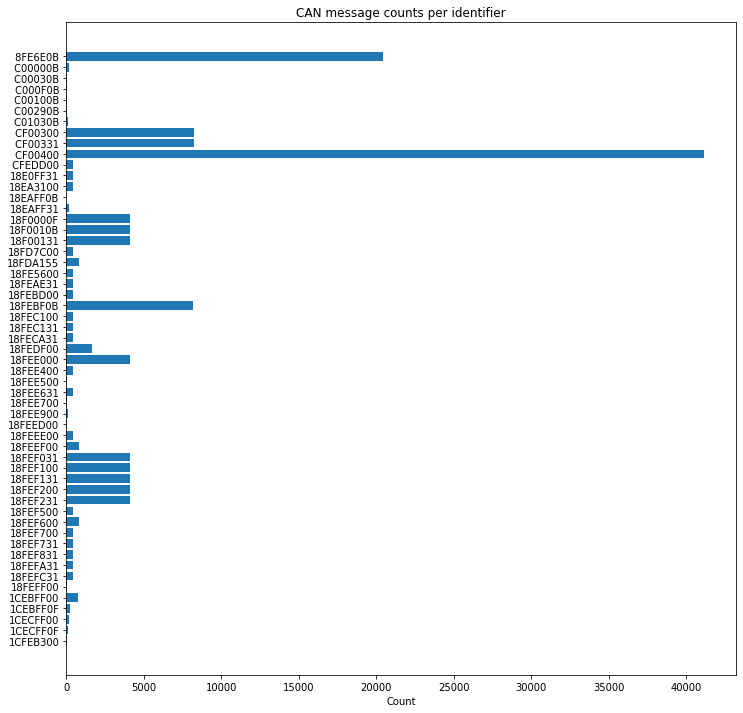

In [29]:
# Plot the bar chart

fig, ax = plt.subplots()

y_pos = [i for i in range(len(can_id_dict))]
counts = [v for k,v in sorted(can_id_dict.items())]
ax.barh(y_pos, counts, align='center')
IDs = ["{:8X}".format(k) for k,v in sorted(can_id_dict.items())]
ax.set_yticks(y_pos)
ax.set_yticklabels(IDs)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('CAN message counts per identifier')

fig.set_figwidth(12)
fig.set_figheight(12)

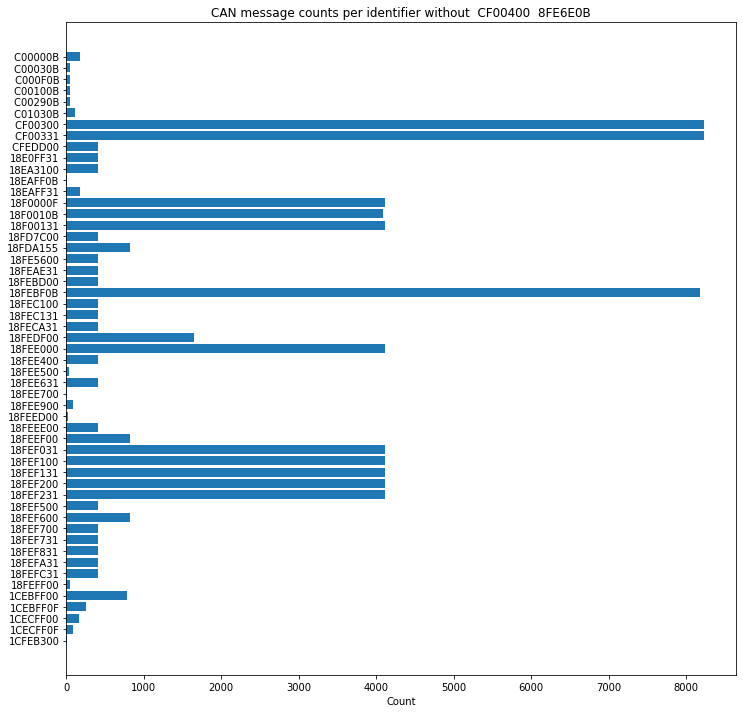

In [30]:
# Produce the same plot without the most frequent messages.
fig, ax = plt.subplots()
exclude = (0xCF00400,0x8Fe6e0b)
y_pos = [i for i in range(len(can_id_dict)-len(exclude))]
counts = [v for k,v in sorted(can_id_dict.items()) if k not in exclude]
ax.barh(y_pos, counts, align='center')
IDs = ["{:8X}".format(k) for k,v in sorted(can_id_dict.items()) if k not in exclude]
ax.set_yticks(y_pos)
ax.set_yticklabels(IDs)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('CAN message counts per identifier without {}'.format(" ".join(["{:8X}".format(i) for i in exclude])))

fig.set_figwidth(12)
fig.set_figheight(12)

### Decoding messages
What to the IDs 0xCF00400,0x8FE6E0B actually mean? We can look these up with the SAE J1939-71 standard, or use the Digital Annex. But first, we have do split the IDs into the J1939 parameters: priority, parameter group number (PGN), destination address (DA), and source address (SA). 

To describe the protocol data unit (PDU), see SAE J1939-21, which may be available from the library. Also, other on-line tutorials also describe the J1939 PDU.

* https://www.csselectronics.com/pages/j1939-explained-simple-intro-tutorial
* https://www.kvaser.com/about-can/higher-layer-protocols/j1939-introduction/
* https://assets.vector.com/cms/content/know-how/_application-notes/AN-ION-1-3100_Introduction_to_J1939.pdf

The key points from these resources are the fact there are two PDU formats. The first format is used for peer-to-peer communications an explicitly includes a source and destination address in the arbitration ID. For these PDU1 messages, the first nibble in the PGN field is a 0xE (14 dec) or lower. The second PDU format is for broadcast messages and the destination is implied to be the global address of 0xFF. These PGNs start with the nibble of 0xF. The function below can parse an extended CAN id into the J1939 parameters.

In [31]:
#parse J1939 protocol data unit information from the ID using bit masks and shifts
PRIORITY_MASK = 0x1C000000
EDP_MASK      = 0x02000000
DP_MASK       = 0x01000000
PF_MASK       = 0x00FF0000
PS_MASK       = 0x0000FF00
SA_MASK       = 0x000000FF
PDU1_PGN_MASK = 0x03FF0000
PDU2_PGN_MASK = 0x03FFFF00

def get_j1939_from_id(can_id):
    #priority
    priority = (PRIORITY_MASK & can_id) >> 26

    #Extended Data Page
    edp = (EDP_MASK & can_id) >> 25
    
    # Data Page
    dp = (DP_MASK & can_id) >> 24
    
    # Protocol Data Unit (PDU) Format
    PF = (can_id & PF_MASK) >> 16
    
    # Protocol Data Unit (PDU) Specific
    PS = (can_id & PS_MASK) >> 8
    
    # Determine the Parameter Group Number and Destination Address
    if PF >= 0xF0: #240
        # PDU 2 format, include the PS as a group extension
        DA = 255
        PGN = (can_id & PDU2_PGN_MASK) >> 8
    else:
        PGN = (can_id & PDU1_PGN_MASK) >> 8
        DA = PS
    # Source address
    SA = (can_id & SA_MASK)
    
    return priority,PGN,DA,SA

In [32]:
# Determine the PGN parameters from our two most frequent messages
get_j1939_from_id(0xCF00400)

(3, 61444, 255, 0)

In [33]:
get_j1939_from_id(0x8Fe6e0b)

(2, 65134, 255, 11)

### Parameter Group Numbers (PGNs)
Look up the PGN from SAE J1939. The standard says this about each PGN:

### PGN 61444 (0x00F004)
Name: `Electronic Engine Controller 1`

Acronym: `EEC1`

Description: `Engine related parameters`

Transmission Repetition Rate: `engine speed dependent` which is normally about 10ms

Data Length: `8`

Extended Data Page: `0`

Data Page: `0`

PDU Format: `240`

PDU Specific: `4`

Default Priority: `3`

#### PGN Supporting Information:

Use this table to understand what parameters are in the data. Keep in mind, Python indexes starting with 0 and J1939 starts with 1.

| Start Position | Length | Parameter Name | SPN |
|:- |:- |:- |:- |
| 1.1 | 4 bits | Engine Torque Mode | 899 |
| 1.5 | 4 bits | Actual Engine - Percent Torque High Resolution | 4154 |
| 2 | 1 byte | Driver's Demand Engine - Percent Torque | 512 |
| 3 | 1 byte | Actual Engine - Percent Torque | 513 |
| 4-5 | 2 bytes | Engine Speed | 190 |
| 6 | 1 byte | Source Address of Controlling Device for Engine Control | 1483 |
| 7.1 | 4 bits | Engine Starter Mode | 1675 |
| 8 | 1 byte | Engine Demand – Percent Torque | 2432 |

### Suspect Parameter Numbers (SPNs)
Also in SAE J1939-71 is a definition for the SPNs. The data are shown below:

#### SPN 190

* Name: `Engine Speed`
* Description: `Actual engine speed which is calculated over a minimum crankshaft angle of 720 degrees divided by the number of cylinders.`
* Data Length: `2 bytes`
* Resolution: `0.125 rpm/bit, 0 offset`
* Data Range: `0 to 8,031.875 rpm`
* Operational Range: `same as data range`
* Type: `Measured`
* PGN reference: `61444`

#### SPN 512

* Name: `Driver's Demand Engine - Percent Torque`
* Description: `The requested torque output of the engine by the driver. It is based on input from the following requestors external to the powertrain: operator (via the accelerator pedal), cruise control and/or road speed limit governor. Dynamic commands from internal powertrain functions such as smoke control, low- and high-speed engine governing; ASR and shift control are excluded from this calculation. The data is transmitted in indicated torque as a percent of the reference engine torque. See PGN 65251 for the engine configuration message. Several status bits are defined separately to indicate the request which is currently being honored. This parameter may be used for shift scheduling.`
* Data Length: `1 byte`
* Resolution: `1 %/bit, -125 % offset`
* Data Range: `-125 to 125 %`
* Operational Range: `0 to 125%`
* Type: `Measured`
* PGN reference: `61444`

There are additional details on the direct interpretation of SPN 512 in Appendix D of SAE J1939-71

In [35]:
# Extract engine speed from the log file from the source Engine #1.
try:
    del time_zero
except NameError:
    pass # the variable doesn't exist

#Setup lists to keep track of the values
PGN61444_time = []
SPN190_value = []
SPN512_value = []

start_time = 50 #seconds
max_time = 100 #seconds

# Use the file in the parent directory

with open('candump_kw_drive.txt', 'r') as f:
    for line in f:
        # Extract the CAN data from each line
        timestamp, channel, can_id, dlc, can_data = parse_candump(line)
        try:
            relative_time = timestamp - time_zero
        except NameError:
            time_zero = timestamp #Assume the first data point is the lowest time
            relative_time = 0
        if relative_time > max_time:
            continue #Don't worry about interpreting any data out of range
        if relative_time < start_time:
            continue
            
        # Interpret the CAN ID in the context of a J1939 message
        priority,PGN,DA,SA = get_j1939_from_id(can_id)
        
        # Look for the EEC1 message from Engine #1
        if PGN == 61444 and SA == 0:
            PGN61444_time.append(relative_time)
       
            spn190 = struct.unpack("<H",can_data[3:5])[0] * 0.125 - 0
            SPN190_value.append(spn190)
            
            spn512 = can_data[1] * 1 - 125
            SPN512_value.append(spn512)
        # Uncomment, fill in and add additional elif statements to look for more PGN,SA combinations of interest
        # elif PGN == ???? and SA == ??:
            #Add similar code here
        else:
            pass #Not interested in any other messages at this time

In [36]:
#Display the times
PGN61444_time[0:5]

[50.00366401672363,
 50.01367497444153,
 50.02460217475891,
 50.033918142318726,
 50.044602155685425]

In [37]:
#display the Values in RPM
SPN190_value[0:5]           

[867.0, 855.5, 855.5, 844.5, 844.5]

In [38]:
#display the demanded torque
SPN512_value[0:5]

[0, 0, 0, 0, 0]

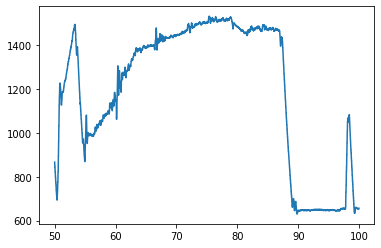

In [39]:
# Take a quick look at the graph for a sanity check
plt.plot(PGN61444_time,SPN190_value)

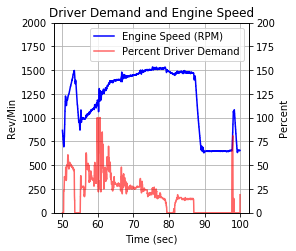

In [40]:
#Let's Create a publication quality graphic for a 2 column paper in word.

# Set the font appearance
plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=12) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plt.rc('legend', fontsize=10) #fontsize of the legend

fig = plt.figure()
# Change the size as needed. 3.5 inches is the right width for a double column
fig.set_figwidth(3.5)
fig.set_figheight(3.5)

ax1= plt.gca() #get current axis
# Plot the engine speed
line1 = ax1.plot(PGN61444_time,
                 SPN190_value,
                 label="Engine Speed (RPM)",
                 color='blue')
plt.grid()
plt.ylabel('Rev/Min')
#Set the limits on both axis to align with gridlines
ax1.set_ylim([0,2000]) 
# Set a tight axis across the bottom
ax1.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('Time (sec)')

# Setup another axis
plt.twinx()
#get current axis, which is the right axis now
ax2 = plt.gca() 
#Plot the driver demand
line2 = ax2.plot(PGN61444_time,
                 SPN512_value,
                 label="Percent Driver Demand",
                 color='red',
                 alpha=0.6)#transparency
# Setting the limits can help move the plots relative to eachother too.
ax2.set_ylim([0,200])
plt.ylabel("Percent")

#build a common legend box
lines = line1+line2
labs = [l.get_label() for l in lines]
plt.legend(lines, labs)

# Give the plot a title
plt.title("Driver Demand and Engine Speed")

# Save the figure in vector forms. The SVG can be imported as a crisp file into Word
plt.savefig('EngineSpeedAndDriverDemand.pdf')
plt.savefig('EngineSpeedAndDriverDemand.svg')

#### Comments
The graph shows the manual action of the driver depressing and releasing the accelerator pedal in the cab of the truck, which gets interpreted as the driver demand. The peak demand is 100%, which means the driver pressed the pedal all the way down. The engine speed usually follows the demand. You can also see shifting patterns, since this vehicle was equipped with a manual transmission, the driver releases the accelerator pedal, the engine speed drops, the gears shift, and the driver continues to accelerate. Towards the end of the graph, the vehicle was approaching a steady speed.

#### Exercise
Confirm this last statement. Add the vehicle speed (SPN84) to this graph to see if the speed becomes steady towards the end of the trace. 

## Summary
In this notebook we looked at the following:
* Converting log files from VSPY and Vector into the candump format
* Determining the number of unique messages in the log file and plotting their occurrence count
* Parsing a CAN ID into the J1939 parameters of priority, parameter group number, destination address, and source address
* Interpreting the contents of the message based on the J1939-71 standard
* Plotting the results of the interpretation of the signals in the CAN log